#### Sepehr Rezaee - 99242067

### CFAR-10 Dataset Classification

#### Import Requirements

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

### Load and Normalize CIFAR-10

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Checking the data

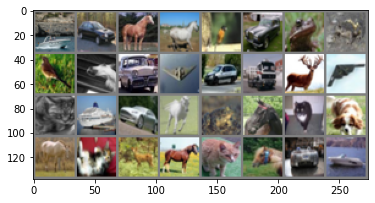

ship  car   horse horse bird  car   frog  frog  bird  horse car   plane car   truck deer  plane cat   ship  car   horse frog  horse cat   dog   deer  cat   deer  horse cat   horse car   ship 


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Requiredment methods

In [ ]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImgClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        accu = accuracy(out,labels)
        return loss,accu

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'Loss': loss.detach(), 'Accuracy': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Loss': epoch_loss.item(), 'Accuracy': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch :",epoch + 1)
        print(f'Train Accuracy:{result["train_accuracy"]*100:.2f}% Validation Accuracy:{result["Accuracy"]*100:.2f}%')
        print(f'Train Loss:{result["train_loss"]:.4f} Validation Loss:{result["Loss"]:.4f}')

### Create the models

In [ ]:
class FirstModel(ImgClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, x):
        return self.network(x)

In [ ]:
class SecondModel(ImgClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.softmax())

    def forward(self, x):
        return self.network(x)

### Training

In [ ]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in data_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader, epochs=20, learning_rate=0.001):
    best_valid = None
    history = []
    optimizer = torch.optim.Adam(model.parameters(), learning_rate,weight_decay=0.0005)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in tqdm(train_loader):
            loss,accu = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        if(best_valid == None or best_valid<result['Accuracy']):
            best_valid=result['Accuracy']
            torch.save(model.state_dict(), 'cifar10-cnn.pth')
        history.append(result)
    return history

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

history1 = fit(FirstModel(), trainloader, testloader)

100%|██████████| 1563/1563 [10:13<00:00,  2.55it/s]


Epoch : 1
Train Accuracy:56.99% Validation Accuracy:69.99%
Train Loss:1.1963 Validation Loss:0.8699


100%|██████████| 1563/1563 [10:16<00:00,  2.54it/s]


Epoch : 2
Train Accuracy:72.75% Validation Accuracy:75.23%
Train Loss:0.7838 Validation Loss:0.7340


100%|██████████| 1563/1563 [10:31<00:00,  2.47it/s]


Epoch : 3
Train Accuracy:77.81% Validation Accuracy:78.62%
Train Loss:0.6426 Validation Loss:0.6293


100%|██████████| 1563/1563 [11:04<00:00,  2.35it/s]


Epoch : 4
Train Accuracy:80.93% Validation Accuracy:79.05%
Train Loss:0.5572 Validation Loss:0.6256


100%|██████████| 1563/1563 [14:35<00:00,  1.79it/s]


Epoch : 5
Train Accuracy:83.18% Validation Accuracy:80.40%
Train Loss:0.4900 Validation Loss:0.5806


 47%|████▋     | 738/1563 [06:21<07:14,  1.90it/s]

In [ ]:
history2 = fit(SecondModel(), trainloader, testloader)

### Plotting accuracy per epoch

In [ ]:
def plot_accuracies(history):
    Validation_accuracies = [x['Accuracy'] for x in history]
    Training_Accuracies = [x['train_accuracy'] for x in history]
    plt.plot(Training_Accuracies, '-rx')
    plt.plot(Validation_accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history1)

In [ ]:
plot_accuracies(history2)

### Plotting loss value per epoch

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['Loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history1)

In [ ]:
plot_losses(history2)

### Testing the model using test data

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
result = evaluate(final_model, test_loader)
print(f'Test Accuracy:{result["Accuracy"]*100:.2f}%')

### Create VGG-net models

In [ ]:
class ThirdModel(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [ ]:

class ForthModel(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
            Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
            Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),
            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),

            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False))
        self.fc = nn.Sequential(
            Linear(in_features=25088, out_features=4096, bias=True),
            ReLU(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=4096, bias=True),
            ReLU(),

            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=1000, bias=True))

        def forward(self, x):
            out = self.layer1(x)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            return out

### Hyperparameters

In [ ]:
num_classes = 10
num_epochs = 20
batch_size = 16
learning_rate = 0.005

model_third = ThirdModel(num_classes)

model_forth = ForthModel(num_classes)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


# Train the model
total_step = len(trainloader)

NameError: name 'VGG19' is not defined

### Training and Testing of VGG-nets model

#### For VGG16

In [ ]:
total_step = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_third(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_third(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

#### For VGG19

In [ ]:
total_step = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_forth(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_forth(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_forth(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))